# Part 3. Tensorflow tutorial - Image segmentation

### Goal of this tutorial:
###     Build and train a model which segments aorta in CT images

## (1) Labelling train images

In [ ]:
# Create ground-truth mask image on Slicer software

In [9]:
import pydicom as dcm
import nibabel as nb 
import numpy as np

import matplotlib.pyplot as plt
import os
import pandas as pd 
import cv2 

#from keras.models import Sequential
#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence

import tensorflow as tf
%matplotlib inline

In [10]:

for dirname, _, filenames in os.walk('./start_deep'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


./start_deep\1. Loading and Visualization.ipynb
./start_deep\.ipynb_checkpoints\1. Loading and Visualization-checkpoint.ipynb
./start_deep\sample_bone_scan\10000.dcm
./start_deep\sample_CT\FILE0000.dcm
./start_deep\sample_CT\FILE0001.dcm
./start_deep\sample_CT\FILE0002.dcm
./start_deep\sample_CT\FILE0003.dcm
./start_deep\sample_CT\FILE0004.dcm
./start_deep\sample_CT\FILE0005.dcm
./start_deep\sample_CT\FILE0006.dcm
./start_deep\sample_CT\FILE0007.dcm
./start_deep\sample_CT\FILE0008.dcm
./start_deep\sample_CT\FILE0009.dcm
./start_deep\sample_CT\FILE0010.dcm
./start_deep\sample_CT\FILE0011.dcm
./start_deep\sample_CT\FILE0012.dcm
./start_deep\sample_CT\FILE0013.dcm
./start_deep\sample_CT\FILE0014.dcm
./start_deep\sample_CT\FILE0015.dcm
./start_deep\sample_CT\FILE0016.dcm
./start_deep\sample_CT\FILE0017.dcm
./start_deep\sample_CT\FILE0018.dcm
./start_deep\sample_CT\FILE0019.dcm
./start_deep\sample_CT\FILE0020.dcm
./start_deep\sample_CT\FILE0021.dcm
./start_deep\sample_CT\FILE0022.dcm
./star

In [11]:
def read_ct(path):
    image=dcm.read_file(path)
    array=image.get_fdata()
    array=np.rot90(np.array(array,dtype=np.float32))
    return array

In [ ]:
data=pd.read_csv("./aorta-ct-scans/aorta_metadata.csv")
data

In [ ]:
CT_scans=data["data_file"]
#Mask_scan=data["segementation_file"]


In [12]:

window_set = {'lung' : (-750-1500/2, -750+1500/2), 'abdomen' : (50-250/2, 50+250/2),
              'mediastinum' : (45-450/2, 45+450/2), 'bone' : (500-2000/2, 500+2000/2),
              'brain' : (40-70/2, 40+70/2), 'pelvis' : (45-300/2, 45+300/2)}

In [13]:
img=read_ct(CT_scans[0])
mask=read_ct(Mask_scan[0])
print(img.shape)
print(mask.shape)
plt.imshow(img[...,24], cmap='gray', vmin=window_set['mediastinum'][0], vmax=window_set['mediastinum'][1])
plt.figure()
plt.imshow(mask[...,24],cmap='gray', vmin=window_set['mediastinum'][0], vmax=window_set['mediastinum'][1])

NameError: name 'CT_scans' is not defined

In [8]:
CT = []
Mask = []
img_size = 64


for case in range(len(data)): #Concat all cases to list
    ct = read_ct(CT_scans[case])
    mask = read_ct(Mask_scan[case])
    
    for imgsize in range(ct.shape[0]):        
        ct_img = cv2.resize(ct[imgsize], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        mask_img = cv2.resize(mask[imgsize],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        CT.append(ct_img[np.newaxis,...])
        Mask.append(mask_img[np.newaxis,...])

In [9]:
CT=np.array(CT)
Mask=np.array(Mask)
mins = CT.min(axis=(1,2,3), keepdims=True)
maxs = CT.max(axis=(1,2,3), keepdims=True)
norm_data = (CT-mins)/(maxs-mins)
CT.shape
#CT=CT.swapaxes(1,3)

(26112, 1, 64, 64)

## (2) Define train/validation set

In [39]:
class CT_dataset(keras.utils.Sequence):
    def __init__(self, CT,Mask):
        self.ct_scans =CT
        self.mask_scan = Mask

    def __len__(self):
        return len(self.ct_scans)

    def __getitem__(self, idx):
        ct=self.ct_scans[idx]
        masks=self.mask_scan[idx]
        return ct,masks


In [40]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(norm_data,Mask,test_size=0.2,random_state=42)

In [58]:
##임의수정 x_train,x_test,y_train,y_test
x_train=x_train.swapaxes(1,3)
y_train=y_train.swapaxes(1,3)
x_test=x_test.swapaxes(1,3)
y_test=y_test.swapaxes(1,3)

In [59]:
train_dataset=CT_dataset(x_train,y_train)
test_dataset=CT_dataset(x_test,y_test)

In [60]:
import numpy as np
import math
from tensorflow.keras.utils import Sequence

class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size, shuffle=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

		# batch 단위로 직접 묶어줘야 함
    def __getitem__(self, idx):
				# sampler의 역할(index를 batch_size만큼 sampling해줌)
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.array(batch_x), np.array(batch_y)

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)
            

train_dl = Dataloader(x_train,y_train, 4, shuffle=True)
valid_dl = Dataloader(x_test,y_test, 1, shuffle=False)


In [61]:
image,label=train_dataset[:400]
#image=image.swapaxes(1,3)
#label=label.swapaxes(1,3)
print(image.shape)
print(label.shape)
plt.imshow(image[300].squeeze(0))
plt.figure()
plt.imshow(label[300].squeeze(0))

(400, 64, 64, 1)
(400, 64, 64, 1)


ValueError: cannot select an axis to squeeze out which has size not equal to one

## (3) Build and train a model

### Method 1 : U-Net

In [62]:
# U-Net : https://arxiv.org/abs/1505.04597
# input shape = output shape : (batch_size, 512, 512, 1)

def unet():
    # encoding + decoding layer with skip connection
    # Fully convolutional network without dense layer 
    # FCN : https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf
    
    # tf.keras.layers.Conv2D
    # tf.keras.layers.MaxPool2D
    # tf.keras.layers.BatchNormalization
    # tf.keras.layers.ReLu
    # tf.keras.layers.Conv2DTranspose or tf.keras.layers.UpSampling2D + tf.keras.layers.Conv2D
    # tf.concat
    # Sigmoid activation at last layer
    
    ...
    ...
    
    return model

In [63]:
from sklearn.model_selection import train_test_split,StratifiedKFold


from tensorflow.keras.layers import Dense, Input, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization,Add,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LeakyReLU, ReLU, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K

In [67]:
def UNet(pretrained_weights = None,input_size = (64,64,1)):
    inp = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inp, outputs=[conv10])

    return model

In [68]:
model = UNet()
model.summary()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_120 (Conv2D)            (None, 64, 64, 64)   640         ['input_6[0][0]']                
                                                                                                  
 conv2d_121 (Conv2D)            (None, 64, 64, 64)   36928       ['conv2d_120[0][0]']             
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 32, 32, 64)  0           ['conv2d_121[0][0]']             
 )                                                                                          

In [69]:
history = model.fit(x_train,y_train,validation_data=(x_test, y_test),epochs = 3)

Epoch 1/3
653/653 [==============================] - 39s 48ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 8.6788e-04 - val_accuracy: 0.9998
Epoch 2/3
653/653 [==============================] - 30s 45ms/step - loss: 7.5694e-04 - accuracy: 0.9998 - val_loss: 8.9618e-04 - val_accuracy: 0.9998
Epoch 3/3
653/653 [==============================] - 30s 46ms/step - loss: 6.9566e-04 - accuracy: 0.9998 - val_loss: 6.7733e-04 - val_accuracy: 0.9998


In [ ]:
예측단계에서 전혀 이해x 
copy본 만들고 시작하기

In [71]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [111]:
for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

AttributeError: 'CT_dataset' object has no attribute 'take'

In [99]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [100]:
show_predictions()

[array([[[0.18823529],
         [0.18823529],
         [0.18823529],
         ...,
         [0.18823529],
         [0.18823529],
         [0.18823529]],
 
        [[0.18823529],
         [0.18823529],
         [0.18823529],
         ...,
         [0.18823529],
         [0.18823529],
         [0.18823529]],
 
        [[0.18823529],
         [0.18823529],
         [0.18823529],
         ...,
         [0.18823529],
         [0.18823529],
         [0.18823529]],
 
        ...,
 
        [[0.18823529],
         [0.18823529],
         [0.18823529],
         ...,
         [0.18823529],
         [0.18823529],
         [0.18823529]],
 
        [[0.18823529],
         [0.18823529],
         [0.18823529],
         ...,
         [0.18823529],
         [0.18823529],
         [0.18823529]],
 
        [[0.18823529],
         [0.18823529],
         [0.18823529],
         ...,
         [0.18823529],
         [0.18823529],
         [0.18823529]]]),
 array([[[0],
         [0],
         [0],
         ...,

In [103]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

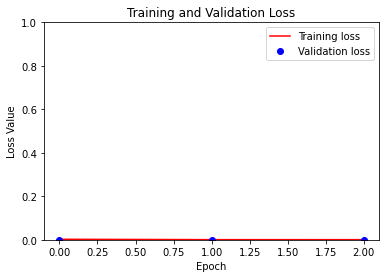

In [108]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [109]:
show_predictions(test_dataset, 3)

AttributeError: 'CT_dataset' object has no attribute 'take'

### Method 2 : 3D U-Net

In [ ]:
# 3D Unet : https://arxiv.org/abs/1606.06650
# input shape : (batch_size, 512, 512, height, 1)

def unet_3D():
    
    # tf.keras.layers.Conv3D
    # tf.keras.layers.MaxPool3D
    # tf.keras.layers.BatchNormalization
    # tf.keras.layers.ReLu
    # tf.keras.layers.Conv3DTranspose or tf.keras.layers.UpSampling3D + tf.keras.layers.Conv3D
    # tf.concat
    # Sigmoid activation at last layer
    
    ...
    ...
    
    return model

In [ ]:
# define a optimizer/metrics and compile the model

model.compile(...)


# print summary of this model
model.summary()

In [ ]:
# Start training

model_history = model.fit(...)

## (4) Plot loss and metrics

In [ ]:
model_history.epoch
model_history.history





## (5) Predict on test set images

In [ ]:
model.predict()

## (6) Saving & loading the trained model

In [ ]:
model.save(...)

## (7) Debugging model/dataset